# BA820 Project Proposal

**Course:** BA820 - Unsupervised and Unstructured Machine Learning  
**Author:** Riya Poojary, Daksh Raichura, Sanskruti Pawar, Michael Allieri

**Primary dataset:** Hollywood Age Gaps (age_gaps.csv)  
**Backup dataset:** African Farm Survey (SAFI) (safi_data.csv)

---

## Executive Summary

This notebook demonstrates **question-driven exploratory data analysis (EDA)** for two datasets:

1. **Hollywood Age Gaps (Primary):** on-screen couples, actor ages, and gender pairings across movies and time.
2. **SAFI Farm Survey (Backup):** household and village-level variation in assets and food security (useful for identifying household archetypes relevant to agricultural interventions).

The goal is to:
- build **domain understanding** before picking algorithms
- discover **patterns** that motivate research questions
- verify whether **unsupervised methods** (clustering / dimensionality reduction) are feasible and meaningful

**Guiding idea:** Unsupervised learning should be motivated by real structure in the data — not just “running K-Means because we can.”


## Table of Contents

### Part I: Hollywood Age Gaps (Primary)
1. Dataset Overview & Research Motivation  
2. Temporal Patterns → *Supports “trajectory / era” clustering question*  
3. Pairing Heterogeneity → *Supports “relationship archetype” question*  
4. Casting Dynamics → *Supports “older-star effect / outliers” question*   
5. Summary: Research Questions Validated

### Part II: African Farm - Led Irrigation System (Backup)
7. Dataset Overview & Research Motivation  
8. Village & Household Heterogeneity → *Supports “targeting / archetypes” question*  
9. Multivariate Relationships → *Supports PCA + clustering at the household level*  
10. Summary: Research Questions Validated

### Part III: Synthesis
11. Key Findings Across Both Datasets  
12. Conclusion / Next Steps


In [17]:
# Install packages
!pip install -q seaborn>=0.12.0 scikit-learn>=1.2.0

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")


In [18]:
# Helper functions

def basic_overview(df, name="Dataset"):
    print(f"===== {name} =====")
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Duplicate rows: {df.duplicated().sum():,}")
    print("\nMissing values (top 10):")
    miss = df.isna().sum().sort_values(ascending=False)
    miss = miss[miss > 0].head(10)
    if len(miss) == 0:
        print("No missing values.")
    else:
        display(miss.to_frame("missing_count"))

def dataset_summary_table(df):
    summary = pd.DataFrame({
        "column": df.columns,
        "dtype": df.dtypes.astype(str),
        "missing": df.isna().sum(),
        "missing_%": (df.isna().mean()*100).round(2),
        "n_unique": df.nunique(dropna=True)
    }).sort_values(["missing_%","n_unique"], ascending=[False, False])
    return summary

def safe_read_csv(path_or_name):

    candidates = [
        path_or_name,
        os.path.join("/content", path_or_name),
    ]
    for p in candidates:
        if os.path.exists(p):
            return pd.read_csv(p)
    raise FileNotFoundError(
        f"Could not find {path_or_name}. If running in Colab, upload the CSVs first."
    )


---
# PART I: HOLLYWOOD AGE GAPS (Primary)

## 1) Dataset Overview & Research Motivation

### Dataset: age_gaps.csv

**What it captures:**  
Each row is an **on-screen couple** in a movie, with actor ages, character genders and the age difference.

**Why this dataset?**
- Real, interpretable topic: media representation + casting patterns
- Natural “grouping” questions (era patterns, pairing types, movie archetypes)
- Suitable for unsupervised learning at the **movie level** (cluster movies by relationship patterns)

### Key variables
- release_year (time)
- age_difference (main outcome of interest)
- actor_1_age, actor_2_age (older vs younger actor)
- character_1_gender, character_2_gender (pairing type)
- movie_name, director, couple_number (identifiers)


In [19]:
# Load dataset
age = safe_read_csv("age_gaps.csv")

basic_overview(age, "Hollywood Age Gaps")
display(age.head())
display(dataset_summary_table(age))


===== Hollywood Age Gaps =====
Shape: 1,155 rows × 13 columns
Duplicate rows: 0

Missing values (top 10):
No missing values.


,movie_name,release_year,director,age_difference,couple_number,actor_1_name,actor_2_name,character_1_gender,character_2_gender,actor_1_birthdate,actor_2_birthdate,actor_1_age,actor_2_age
0,Harold and Maude,1971,Hal Ashby,52,1,Ruth Gordon,Bud Cort,woman,man,1896-10-30,1948-03-29,75,23
1,Venus,2006,Roger Michell,50,1,Peter O'Toole,Jodie Whittaker,man,woman,1932-08-02,1982-06-03,74,24
2,The Quiet American,2002,Phillip Noyce,49,1,Michael Caine,Do Thi Hai Yen,man,woman,1933-03-14,1982-10-01,69,20
3,The Big Lebowski,1998,Joel Coen,45,1,David Huddleston,Tara Reid,man,woman,1930-09-17,1975-11-08,68,23
4,Beginners,2010,Mike Mills,43,1,Christopher Plummer,Goran Visnjic,man,man,1929-12-13,1972-09-09,81,38


,column,dtype,missing,missing_%,n_unique
movie_name,movie_name,object,0,0.0,830
actor_2_name,actor_2_name,object,0,0.0,647
actor_2_birthdate,actor_2_birthdate,object,0,0.0,640
actor_1_name,actor_1_name,object,0,0.0,567
actor_1_birthdate,actor_1_birthdate,object,0,0.0,562
director,director,object,0,0.0,510
release_year,release_year,int64,0,0.0,82
actor_1_age,actor_1_age,int64,0,0.0,59
age_difference,age_difference,int64,0,0.0,46
actor_2_age,actor_2_age,int64,0,0.0,45


## 2) Temporal Patterns

**Research Question:**  
Do age gaps change over time  and can we identify “eras” or trajectories where movies show different age-gap patterns?

**What we check here:**
- trend in average age gap by year
- distribution shifts over time (decades)


,release_year,count,mean,median,std
0,1935,2,13.000000,13.0,8.485281
1,1936,1,21.000000,21.0,NaN
2,1937,3,7.333333,9.0,5.686241
3,1939,1,12.000000,12.0,NaN
4,1940,3,11.333333,10.0,9.073772


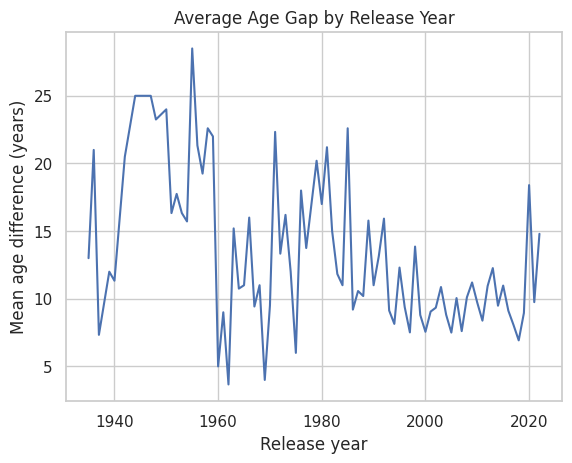

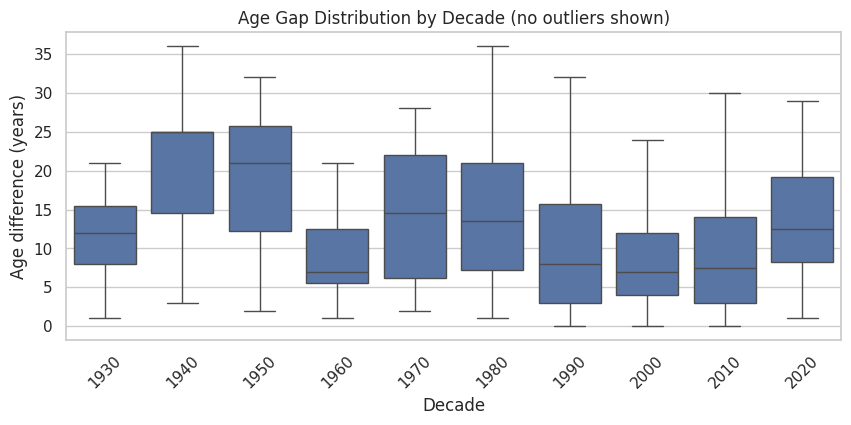

In [21]:
# Mean age gap trend by year
year_stats = age.groupby("release_year")["age_difference"].agg(["count","mean","median","std"]).reset_index()
display(year_stats.head())

plt.figure()
plt.plot(year_stats["release_year"], year_stats["mean"])
plt.title("Average Age Gap by Release Year")
plt.xlabel("Release year")
plt.ylabel("Mean age difference (years)")
plt.show()

# Decade-based distribution
age["decade"] = (age["release_year"] // 10) * 10

plt.figure(figsize=(10,4))
sns.boxplot(data=age, x="decade", y="age_difference", showfliers=False)
plt.title("Age Gap Distribution by Decade (no outliers shown)")
plt.xlabel("Decade")
plt.ylabel("Age difference (years)")
plt.xticks(rotation=45)
plt.show()



**Interpretation:**
- If the mean trend declines, it suggests age gaps are shrinking over time.
- If the decade boxplots tighten or shift down, the whole distribution is changing.
- The “Gap ≥ 20” or “Gap ≥ 30” trend tells you if extreme gaps are becoming rarer or not.


## 3) Pairing Heterogeneity

**Research Question:**  
Do different gender pairings have systematically different age-gap patterns?

**Why it matters:**
- If pairings have very different distributions, we can treat them as different archetypes
- This supports clustering movies based on composition of relationship types


,pairing,count,pct
0,man–woman,929,80.4
1,woman–man,203,17.6
2,man–man,12,1.0
3,woman–woman,11,1.0


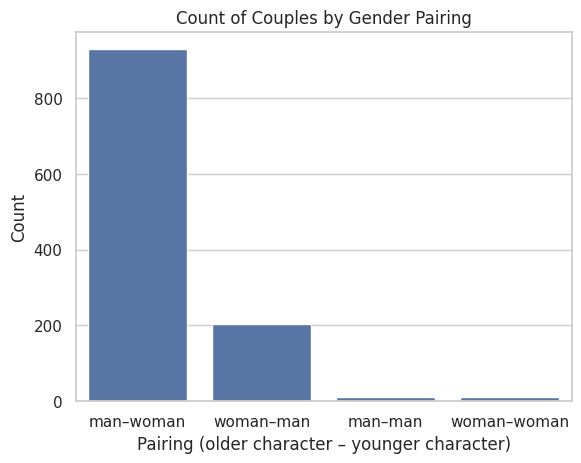

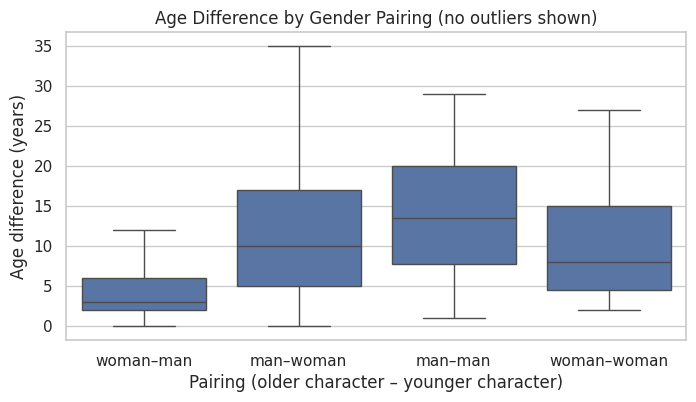

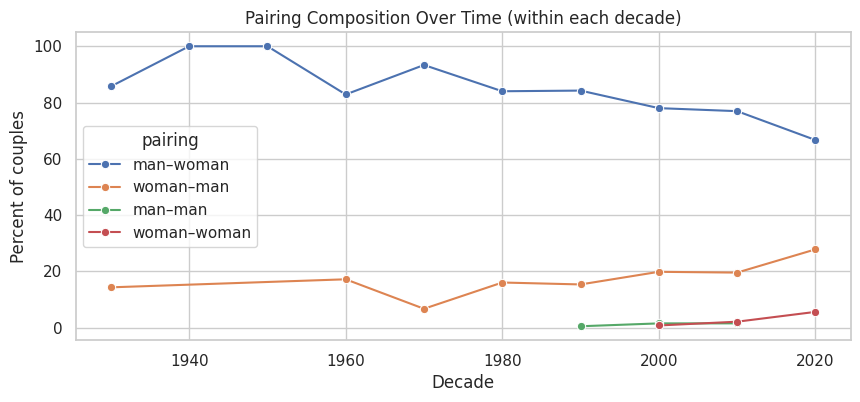

In [23]:
age["pairing"] = (
    age["character_1_gender"].astype(str).str.strip().str.lower()
    + "–" +
    age["character_2_gender"].astype(str).str.strip().str.lower()
)

age["decade"] = (age["release_year"] // 10) * 10

# Pairing counts
pair_counts = age["pairing"].value_counts().rename_axis("pairing").reset_index(name="count")
pair_counts["pct"] = (pair_counts["count"]/len(age)*100).round(1)
display(pair_counts)

plt.figure()
sns.barplot(data=pair_counts, x="pairing", y="count")
plt.title("Count of Couples by Gender Pairing")
plt.xlabel("Pairing (older character – younger character)")
plt.ylabel("Count")
plt.show()

# Age gap distributions by pairing
plt.figure(figsize=(8,4))
sns.boxplot(data=age, x="pairing", y="age_difference", showfliers=False)
plt.title("Age Difference by Gender Pairing (no outliers shown)")
plt.xlabel("Pairing (older character – younger character)")
plt.ylabel("Age difference (years)")
plt.show()

# Pairing mix over decades (composition)
mix = (
    age.groupby(["decade","pairing"])
       .size()
       .reset_index(name="n")
)
mix["pct_within_decade"] = mix.groupby("decade")["n"].transform(lambda x: x/x.sum()*100)

plt.figure(figsize=(10,4))
sns.lineplot(data=mix, x="decade", y="pct_within_decade", hue="pairing", marker="o")
plt.title("Pairing Composition Over Time (within each decade)")
plt.xlabel("Decade")
plt.ylabel("Percent of couples")
plt.show()


**Interpretation:**
- Which pairing has the highest median age gap?
- Is the dataset dominated by one pairing type?
- Does the mix change over decades?


## 4) Casting Dynamics

**Research Question:**  
Are large age gaps mainly driven by very old lead actors paired with much younger partners?  
Do some directors/movies consistently show larger gaps?

**What we check here:**
- relationship between actor_1_age and age_difference
- top directors by average age gap
- movies with multiple couples


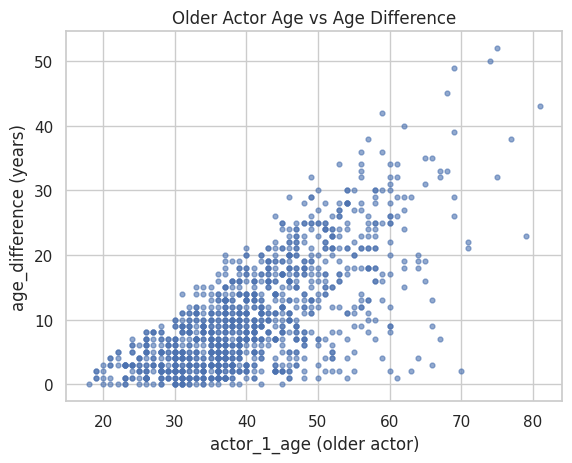

,director,n,avg_gap,med_gap
413,Roger Michell,3,30.000000,33.0
123,Eli Roth,3,22.000000,24.0
13,Alfred Hitchcock,7,21.000000,22.0
317,Michel Gondry,3,20.666667,15.0
202,Jerry Zucker,3,20.333333,16.0
504,Woody Allen,20,20.150000,18.5
217,John Glen,15,19.866667,21.0
171,Howard Hawks,4,19.250000,24.5
236,Jonathan Lynn,4,19.250000,19.0
209,Joel Coen,5,19.000000,11.0


,movie_name,n_couples
0,Love Actually,7
1,The Family Stone,6
2,Mona Lisa Smile,5
3,He's Just Not That Into You,5
4,A View to a Kill,5
5,A Star Is Born,4
6,Sex and the City,4
7,The Favourite,4
8,Boogie Nights,4
9,The Girl on the Train,4


,movie_name,release_year,director,actor_1_name,actor_1_age,actor_2_name,actor_2_age,pairing,age_difference
0,Harold and Maude,1971,Hal Ashby,Ruth Gordon,75,Bud Cort,23,woman–man,52
1,Venus,2006,Roger Michell,Peter O'Toole,74,Jodie Whittaker,24,man–woman,50
2,The Quiet American,2002,Phillip Noyce,Michael Caine,69,Do Thi Hai Yen,20,man–woman,49
3,The Big Lebowski,1998,Joel Coen,David Huddleston,68,Tara Reid,23,man–woman,45
4,Beginners,2010,Mike Mills,Christopher Plummer,81,Goran Visnjic,38,man–man,43
5,Poison Ivy,1992,Katt Shea,Tom Skerritt,59,Drew Barrymore,17,man–woman,42
6,Whatever Works,2009,Woody Allen,Larry David,62,Evan Rachel Wood,22,man–woman,40
7,Entrapment,1999,Jon Amiel,Sean Connery,69,Catherine Zeta-Jones,30,man–woman,39
8,Husbands and Wives,1992,Woody Allen,Woody Allen,57,Juliette Lewis,19,man–woman,38
9,Magnolia,1999,Paul Thomas Anderson,Jason Robards,77,Julianne Moore,39,man–woman,38


In [24]:
# Relationship: older actor age vs age gap
plt.figure()
plt.scatter(age["actor_1_age"], age["age_difference"], s=12, alpha=0.6)
plt.title("Older Actor Age vs Age Difference")
plt.xlabel("actor_1_age (older actor)")
plt.ylabel("age_difference (years)")
plt.show()

# Top directors by average age gap
dir_stats = (
    age.groupby("director")["age_difference"]
       .agg(n="size", avg_gap="mean", med_gap="median")
       .reset_index()
)
dir_stats = dir_stats[dir_stats["n"] >= 3].sort_values("avg_gap", ascending=False)
display(dir_stats.head(15))

# Movies with multiple couples recorded
movie_couples = age.groupby("movie_name")["couple_number"].nunique().sort_values(ascending=False)
multi = movie_couples[movie_couples > 1].head(15).rename_axis("movie_name").reset_index(name="n_couples")
display(multi)

# Show the biggest gaps
top_gaps = age.sort_values("age_difference", ascending=False).head(15)[
    ["movie_name","release_year","director","actor_1_name","actor_1_age","actor_2_name","actor_2_age","pairing","age_difference"]
]
display(top_gaps)


**Interpretation:**
- If points fan out as actor_1_age increases, it supports an older-star effect.
- Directors with consistently higher gaps may reflect casting style.
- Outlier table is useful for storytelling + validating that extreme values are real.


## 5) Summary: Research Questions (Primary)

**What this EDA helps validate:**
- **Time structure exists** (decade differences), supporting “era” or trajectory-based clustering.
- **Pairings differ** in their age-gap distributions, supporting relationship archetypes.




---
# PART II: African Farm - Led Irrigation System (Backup)

## 7) Dataset Overview

### Dataset: safi_data.csv

This dataset is a small household/village survey. It includes:
- household size (no_membrs)
- number of rooms (rooms)
- wall type (respondent_wall_type)
- livestock count (liv_count)
- assets owned (items_owned, semi-colon separated)
- food security proxy (no_meals, months_lack_food)
- village (village) and interview date (interview_date)

**Why it works as a backup for unsupervised learning:**
- clear heterogeneity across households and villages
- many “profiles” likely exist (asset-rich vs asset-poor, food secure vs insecure)
- clustering can help target interventions (including agricultural support / irrigation programs)



In [35]:
# Load dataset

safi = safe_read_csv("safi_data.csv")

basic_overview(safi, "SAFI Farm Survey")
display(safi.head())
display(dataset_summary_table(safi))


===== SAFI Farm Survey =====
Shape: 131 rows × 14 columns
Duplicate rows: 0

Missing values (top 10):


,missing_count
affect_conflicts,39
memb_assoc,39
items_owned,10


,key_ID,village,interview_date,no_membrs,years_liv,respondent_wall_type,rooms,memb_assoc,affect_conflicts,liv_count,items_owned,no_meals,months_lack_food,instanceID
0,1,God,2016-11-17T00:00:00Z,3,4,muddaub,1,NaN,NaN,1,bicycle;television;solar_panel;table,2,Jan,uuid:ec241f2c-0609-46ed-b5e8-fe575f6cefef
1,1,God,2016-11-17T00:00:00Z,7,9,muddaub,1,yes,once,3,cow_cart;bicycle;radio;cow_plough;solar_panel;...,2,Jan;Sept;Oct;Nov;Dec,uuid:099de9c9-3e5e-427b-8452-26250e840d6e
2,3,God,2016-11-17T00:00:00Z,10,15,burntbricks,1,NaN,NaN,1,solar_torch,2,Jan;Feb;Mar;Oct;Nov;Dec,uuid:193d7daf-9582-409b-bf09-027dd36f9007
3,4,God,2016-11-17T00:00:00Z,7,6,burntbricks,1,NaN,NaN,2,bicycle;radio;cow_plough;solar_panel;mobile_phone,2,Sept;Oct;Nov;Dec,uuid:148d1105-778a-4755-aa71-281eadd4a973
4,5,God,2016-11-17T00:00:00Z,7,40,burntbricks,1,NaN,NaN,4,motorcyle;radio;cow_plough;mobile_phone,2,Aug;Sept;Oct;Nov,uuid:2c867811-9696-4966-9866-f35c3e97d02d


,column,dtype,missing,missing_%,n_unique
affect_conflicts,affect_conflicts,object,39,29.77,4
memb_assoc,memb_assoc,object,39,29.77,2
items_owned,items_owned,object,10,7.63,95
instanceID,instanceID,object,0,0.00,131
key_ID,key_ID,int64,0,0.00,129
years_liv,years_liv,int64,0,0.00,50
months_lack_food,months_lack_food,object,0,0.00,31
interview_date,interview_date,object,0,0.00,19
no_membrs,no_membrs,int64,0,0.00,15
respondent_wall_type,respondent_wall_type,object,0,0.00,6


In [40]:
# Feature engineering for SAFI
safi2 = safi.copy()

# Parse date
safi2["interview_date"] = pd.to_datetime(safi2["interview_date"], errors="coerce")

# Count items owned
safi2["items_owned"] = safi2["items_owned"].fillna("")
safi2["items_owned_count"] = safi2["items_owned"].apply(lambda x: 0 if x.strip()=="" else len(x.split(";")))

# Food insecurity: number of months lacking food
safi2["months_lack_food"] = safi2["months_lack_food"].fillna("")
safi2["months_lack_food_count"] = safi2["months_lack_food"].apply(lambda x: 0 if x.strip()=="" else len(x.split(";")))

# Membership association
safi2["memb_assoc_flag"] = safi2["memb_assoc"].map({"yes":1, "no":0})

display(safi2[["village","no_membrs","rooms","liv_count","items_owned_count","no_meals","months_lack_food_count","memb_assoc"]].head())

,village,no_membrs,rooms,liv_count,items_owned_count,no_meals,months_lack_food_count,memb_assoc
0,God,3,1,1,4,2,1,NaN
1,God,7,1,3,8,2,5,yes
2,God,10,1,1,1,2,6,NaN
3,God,7,1,2,5,2,4,NaN
4,God,7,1,4,4,2,4,NaN


## 8) Village & Household Heterogeneity

**Research Question:**  
Do villages/households form distinct “resource and vulnerability archetypes” based on assets and food security?

**What we check here:**
- distribution of assets and food insecurity
- differences across villages
- relationship between assets and food insecurity


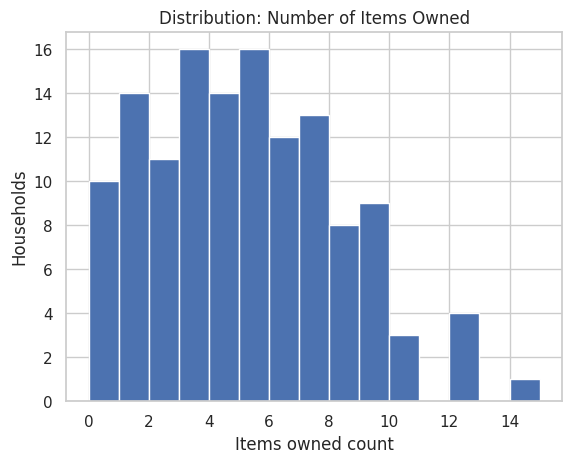

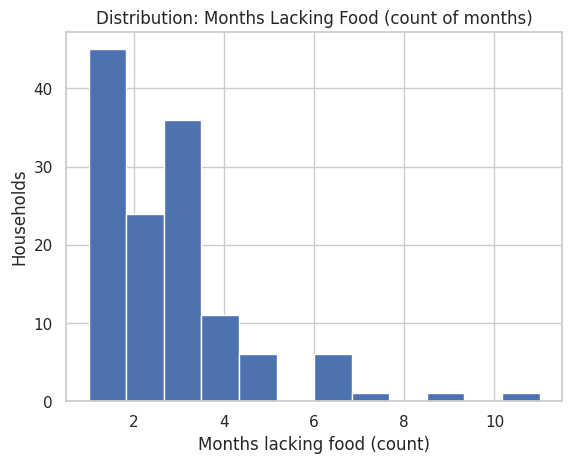

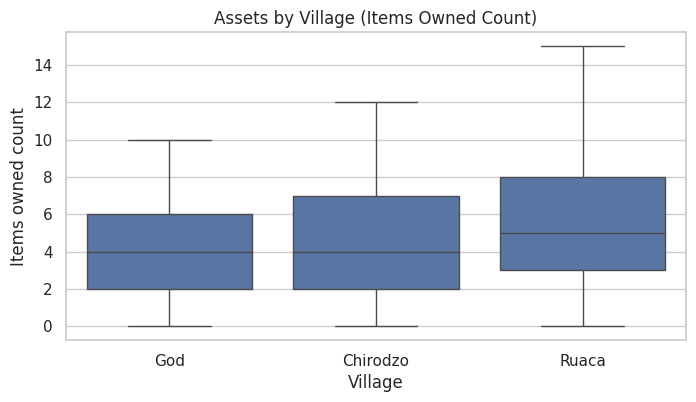

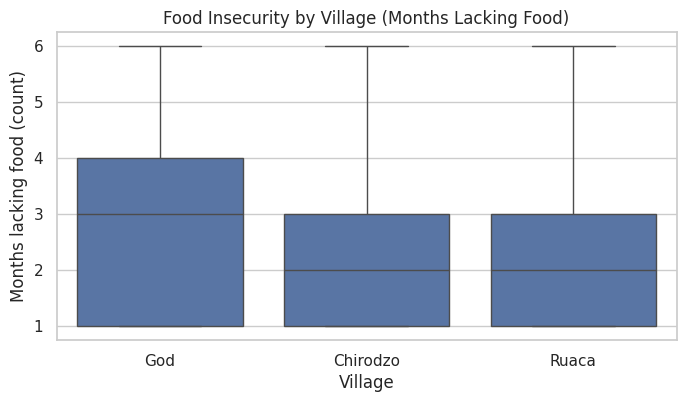

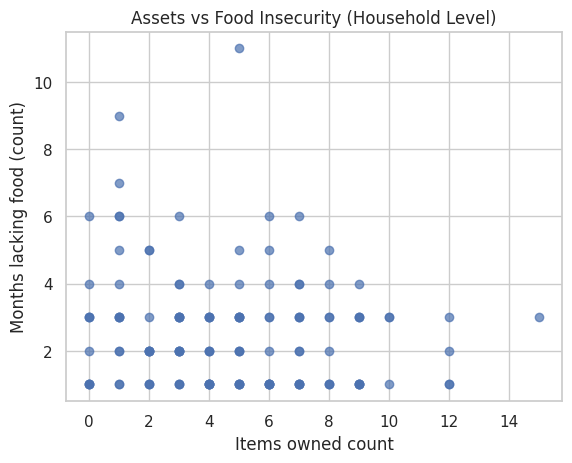

,village,n,avg_items,avg_months_lack_food,avg_livestock,avg_household_size
0,Chirodzo,39,4.54,2.44,2.26,7.08
1,God,43,3.98,3.09,2.23,6.86
2,Ruaca,49,5.57,2.24,2.57,7.57


In [42]:
# Distributions
plt.figure()
plt.hist(safi2["items_owned_count"], bins=15)
plt.title("Distribution: Number of Items Owned")
plt.xlabel("Items owned count")
plt.ylabel("Households")
plt.show()

plt.figure()
plt.hist(safi2["months_lack_food_count"], bins=12)
plt.title("Distribution: Months Lacking Food (count of months)")
plt.xlabel("Months lacking food (count)")
plt.ylabel("Households")
plt.show()

# Village comparison
plt.figure(figsize=(8,4))
sns.boxplot(data=safi2, x="village", y="items_owned_count", showfliers=False)
plt.title("Assets by Village (Items Owned Count)")
plt.xlabel("Village")
plt.ylabel("Items owned count")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(data=safi2, x="village", y="months_lack_food_count", showfliers=False)
plt.title("Food Insecurity by Village (Months Lacking Food)")
plt.xlabel("Village")
plt.ylabel("Months lacking food (count)")
plt.show()

# Relationship: assets vs food insecurity
plt.figure()
plt.scatter(safi2["items_owned_count"], safi2["months_lack_food_count"], alpha=0.7)
plt.title("Assets vs Food Insecurity (Household Level)")
plt.xlabel("Items owned count")
plt.ylabel("Months lacking food (count)")
plt.show()

# Summary table by village
village_stats = safi2.groupby("village").agg(
    n=("key_ID","size"),
    avg_items=("items_owned_count","mean"),
    avg_months_lack_food=("months_lack_food_count","mean"),
    avg_livestock=("liv_count","mean"),
    avg_household_size=("no_membrs","mean")
).round(2).reset_index()

display(village_stats)


**Interpretation:**
- If villages differ strongly, it supports a “context matters” story (targeting by location).
- If assets and food insecurity are negatively related, that supports an intervention prioritization logic.


## 9) Multivariate Relationships (Household-Level)

**Goal:** build a household feature table so we can:
- reduce dimensions (PCA)
- cluster households into interpretable profiles (e.g., “asset-rich & food-secure” vs “asset-poor & food-insecure”)

This is useful for:
- targeting support programs
- segmenting households for different interventions


,PC,explained_variance_pct
0,PC1,17.56
1,PC2,10.70
2,PC3,10.17
3,PC4,8.33
4,PC5,7.18
5,PC6,6.81


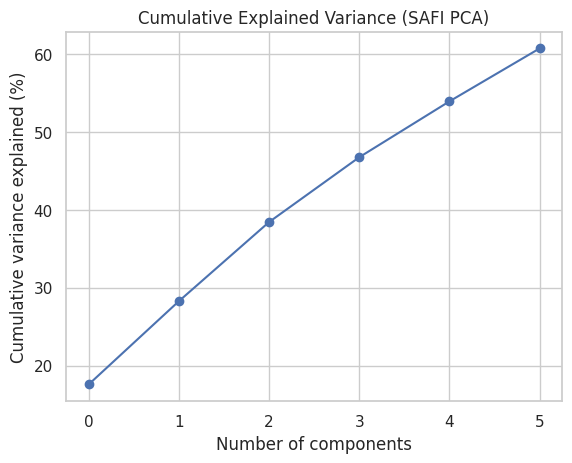

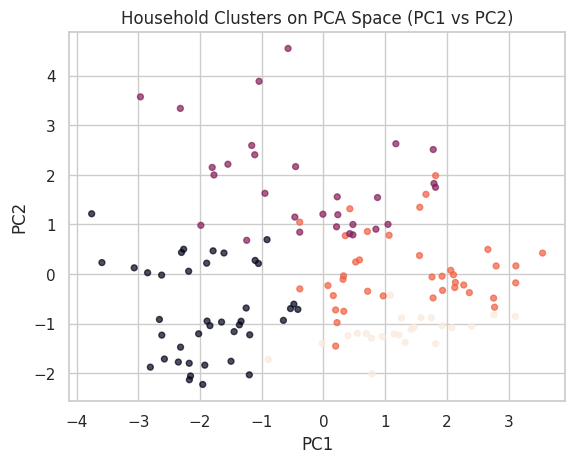

,no_membrs,years_liv,rooms,liv_count,items_owned_count,no_meals,months_lack_food_count
cluster,,,,,,,
0,5.18,20.95,1.18,1.62,2.22,2.60,2.72
1,7.83,19.14,1.66,2.41,4.66,2.52,3.41
2,8.15,26.87,1.85,3.03,6.79,2.69,2.13
3,8.26,25.17,2.65,2.48,5.74,2.57,2.04


village,Chirodzo,God,Ruaca
cluster,,,
0,0.35,0.32,0.32
1,0.00,1.00,0.00
2,0.08,0.03,0.90
3,0.96,0.00,0.04


In [43]:
# Build household feature table
hh = safi2[[
    "village","no_membrs","years_liv","rooms","liv_count",
    "items_owned_count","no_meals","months_lack_food_count",
    "respondent_wall_type","memb_assoc_flag"
]].copy()

# Fill missing numeric values
num_cols = ["no_membrs","years_liv","rooms","liv_count","items_owned_count","no_meals","months_lack_food_count"]
for c in num_cols:
    hh[c] = pd.to_numeric(hh[c], errors="coerce")
    hh[c] = hh[c].fillna(hh[c].median())

hh["memb_assoc_flag"] = pd.to_numeric(hh["memb_assoc_flag"], errors="coerce").fillna(0)

# Categorical to dummies
hh_model = pd.get_dummies(hh, columns=["village","respondent_wall_type"], dummy_na=True)

X = hh_model.apply(pd.to_numeric, errors="coerce")

imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# PCA
pca = PCA(n_components=6, random_state=42)
X_pca = pca.fit_transform(X_scaled)

explained = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    "explained_variance_pct": (pca.explained_variance_ratio_*100).round(2)
})
display(explained)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, marker="o")
plt.title("Cumulative Explained Variance (SAFI PCA)")
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance explained (%)")
plt.show()

# KMeans clustering (start with k=4)
k = 4
km = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = km.fit_predict(X_pca[:, :3])

hh["cluster"] = clusters

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, s=18, alpha=0.7)
plt.title("Household Clusters on PCA Space (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Cluster profiles (interpretation)
profile = hh.groupby("cluster")[num_cols].mean().round(2)
display(profile)

# Village composition by cluster
cluster_mix = pd.crosstab(hh["cluster"], hh["village"], normalize="index").round(2)
display(cluster_mix)


## 10) Summary: Research Questions (Backup)

- There is strong household-level heterogeneity (assets, food insecurity, livestock).
- Villages show different patterns, supporting a context + targeting story.
- PCA + clustering creates interpretable household archetypes, which is exactly the kind of structure unsupervised learning is meant to reveal.


---
# PART III: Findings

## 11) Key Findings Across Both Datasets

**Common theme:** both datasets show meaningful heterogeneity that supports segmentation.

- **Hollywood:** movies differ by era, pairing composition and typical age-gap structure to natural movie archetypes
- **SAFI:** households differ by assets and food security to natural household archetypes

In both cases, unsupervised learning helps answer:  
**“What kinds of groups exist in the data and how are they different?”**


## 12) Conclusion

**What this notebook accomplishes:**
- clean, question-driven EDA
- clear motivation for unsupervised methods (PCA + clustering)


